# TestCase4 - ErrorMap

In [1]:
# sélection du cas test
testcase = 4
version = 4
degree = 1
param_num = 1

**Idée :** On se place ici dans le TestCase3.

On cherche à afficher des cartes d'erreur sur la solution.

## Imports + Load

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import pandas as pd
import os
import dolfin as df
import seaborn as sns

# from modules.fenics_expressions import UexExpr
from scimba.equations.domain import SpaceTensor
from scimba.equations import domain

from modules.utils import create_tree
from modules.geometry import Donut,Circle
from modules.fenics_expressions import FExpr,UexExpr

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


Using device: cpu


/home/flecourtier/anaconda3/envs/phifem_scimba_2/lib/python3.9/site-packages/torch/cuda/__init__.py:138: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at /opt/conda/conda-bld/pytorch_1702400441250/work/c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0


In [4]:
if testcase == 4:
    if version == 1:
        from modules.testcases.d2.test_4.test_4_v1 import Run_laplacian2D,Poisson_2D
        from modules.solver_fem_4 import FEMSolver
    elif version == 2:
        from modules.testcases.d2.test_4.test_4_v2 import Run_laplacian2D,Poisson_2D
        from modules.solver_fem_4_donut import FEMSolver
    elif version == 3:
        from modules.testcases.d2.test_4.test_4_v3 import Run_laplacian2D,Poisson_2D
        from modules.solver_fem_4_donut import FEMSolver
    elif version == 4:
        from modules.testcases.d2.test_4.test_4_v4 import Run_laplacian2D,Poisson_2D
        from modules.solver_fem_4_donut_v4 import FEMSolver
    elif version == 5:
        from modules.testcases.d2.test_4.test_4_v5 import Run_laplacian2D,Poisson_2D
        from modules.solver_fem_4_donut_v5 import FEMSolver
    else:
        raise ValueError("Version not found")
    from modules.problem import TestCase4
    problem = TestCase4(v=version)
else:
    raise ValueError("Testcase not found")


dim_params = problem.nb_parameters
result_dir = "../../../results/2D/testcase"+str(testcase)+"/version"+str(version)
result_dir += "/errormap/"
create_tree(result_dir)

tab_nb_vert = [20,40]
tab_h = []
for nb_vert in tab_nb_vert:
    solver = FEMSolver(nb_cell=nb_vert-1, params=[[]], problem=problem, degree=degree)
    tab_h.append(np.round(solver.mesh.hmax(),2))

torch loaded; device is cpu
hmax =  0.13314799984383346
hmax =  0.06893171898161234


>> load network /home/flecourtier/Bureau/Article1/code/networks/test_fe4_v4.pth
network was not loaded from file: training needed


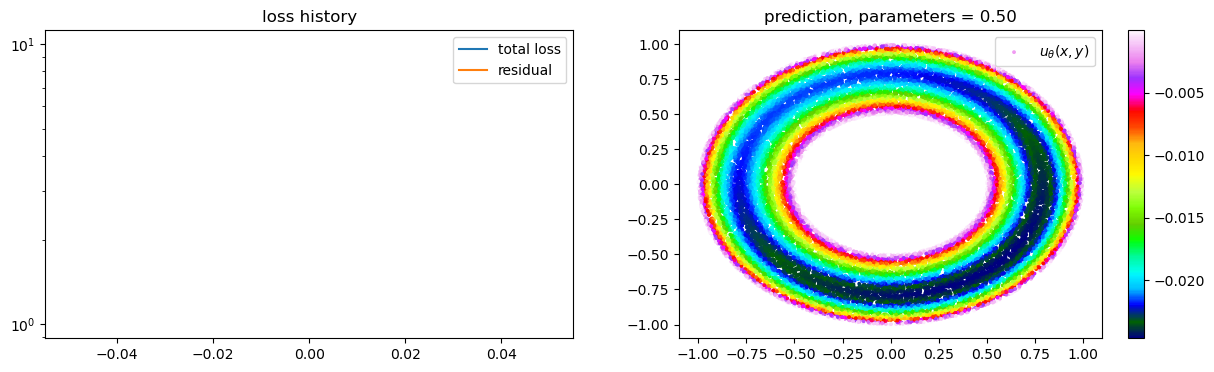

In [5]:
pde = Poisson_2D()
trainer,u_theta = Run_laplacian2D(pde)

In [6]:
def get_param(i):
    parameter_domain = trainer.pde.parameter_domain.cpu().numpy()
    # pick 1 random parameter
    np.random.seed(0)
    for j in range(i):
        param = []
        for k in range(len(parameter_domain)):
            param.append(np.random.uniform(parameter_domain[k][0], parameter_domain[k][1]))
    param = np.round(param, 2)
    return param

param = get_param(param_num)
params = [param]
params_str = np.array([f"{param}"])
params

[array([0.5])]

## Solution de référence

In [7]:
from dolfin import *
prm = parameters["krylov_solver"]
prm["absolute_tolerance"] = 1e-13
prm["relative_tolerance"] = 1e-13

In [8]:
import mshr

def create_ref_domain(deg,nb_vert=500,H=None):    
    # check if pb_considered is instance of Square class
    if isinstance(problem.geometry, Donut):
        bigcenter = problem.geometry.bigcircle.center
        bigradius = problem.geometry.bigcircle.radius
        smallcenter = problem.geometry.hole.center
        smallradius = problem.geometry.hole.radius
        box = np.array(problem.geometry.box)

        bigcircle = mshr.Circle(df.Point(bigcenter[0],bigcenter[1]), bigradius)
        hole = mshr.Circle(df.Point(smallcenter[0],smallcenter[1]), smallradius)
        domain = bigcircle-hole    
    
        mesh_macro = RectangleMesh(Point(box[0,0], box[1,0]), Point(box[0,1], box[1,1]), nb_vert, nb_vert)
        h_macro = mesh_macro.hmax()
        print("h_macro = ",h_macro)
        
        if H is None:
            # H = int(nb_vert*3/5)
            H=350
        else:
            H = int(H)
        mesh_ref = mshr.generate_mesh(domain,H)
        h = mesh_ref.hmax()
        while h > h_macro:
            H += 1
            mesh_ref = mshr.generate_mesh(domain,H)            
            h = mesh_ref.hmax()
            print("h : ",h)
    elif isinstance(problem.geometry, Circle):
        center = problem.geometry.center
        radius = problem.geometry.radius
        box = np.array(problem.geometry.box)

        domain = mshr.Circle(df.Point(center[0],center[1]), radius)        
        mesh_macro = RectangleMesh(Point(box[0,0], box[1,0]), Point(box[0,1], box[1,1]), nb_vert, nb_vert)
        h_macro = mesh_macro.hmax()
        print("h_macro = ",h_macro)
        
        if H is None:
            # H = int(nb_vert*3/5)
            H = 700
        else:
            H = int(H)
        mesh_ref = mshr.generate_mesh(domain,H)
        h = mesh_ref.hmax()
        while h > h_macro:
            H += 1
            mesh_ref = mshr.generate_mesh(domain,H)
            h = mesh_ref.hmax()
            print("h : ",h)
    else:
        raise ValueError("Geometry not implemented")
    
    V_ref = df.FunctionSpace(mesh_ref, "CG", deg)
    print(V_ref.tabulate_dof_coordinates().shape)
    dx_ref = df.Measure("dx", domain=mesh_ref)
    
    h_ref = mesh_ref.hmax()
    print("hmax = ",h_ref)

    return mesh_ref, V_ref, dx_ref, H
    
def get_uref(param,deg,nb_vert=500,H=None):
    mesh_ref, V_ref, dx_ref, H = create_ref_domain(deg,nb_vert,H)
    
    f_expr = FExpr(param, degree=deg, domain=mesh_ref, pb_considered=problem)  
    
    g = Constant("0.0")
    
    if version ==1: # circle
        def boundary_D(x,on_boundary):
            return on_boundary and x[1]>=0.0 #and x[0]**2+x[1]**2>1.0-DOLFIN_EPS
            
        bc = DirichletBC(V_ref, g, boundary_D)
    elif version == 2 or version == 3: # donut (Dir int, Neu ext)
        def boundary_D(x,on_boundary):
            return on_boundary and x[0]**2+x[1]**2<0.75**2
        
        bc = DirichletBC(V_ref, g, boundary_D)
    elif version == 4: # donut (Dir partout)
        print("v4")
        bc = DirichletBC(V_ref, g, "on_boundary") 
    elif version == 5: # donut (Dir partout)
        bc = None
    else:
        raise ValueError("Version not found")
    
    u = df.TrialFunction(V_ref)
    v = df.TestFunction(V_ref)
    
    # Resolution of the variationnal problem

    if version < 5:
        a = df.inner(df.grad(u),df.grad(v)) * dx_ref
    elif version == 5:
        a = df.inner(df.grad(u),df.grad(v)) * dx_ref + u*v*dx_ref
    else:
        raise ValueError("Version not found")
    l = f_expr * v * dx_ref
    if version == 5:
        h_int = Constant("-0.5")
        h_ext = Constant("2.0")
        ds_ref = df.Measure("ds", domain=mesh_ref)
        l += h_int*v*ds_ref

    # solver = dol.KrylovSolver('cg', 'hypre_amg')
    # prm = solver.parameters
    # print(prm["absolute_tolerance"],prm["relative_tolerance"])
    # prm["absolute_tolerance"] = 1E-10
    # prm["relative_tolerance"] = 1E-10

    sol = df.Function(V_ref)
    # solver.solve(a==l, sol, bcs=bc)
    if bc != None:
        df.solve(a==l, sol, bcs=bc, solver_parameters={"linear_solver": "cg","preconditioner":"hypre_amg"})
    else:
        df.solve(a==l, sol, solver_parameters={"linear_solver": "cg","preconditioner":"hypre_amg"})

    return sol,H


In [9]:
if testcase != 4:
    savedir = result_dir + "u_ref/"
    create_tree(savedir)

    nb_vert = 500
    deg_uref = 3

    filename = f"u_ref_{param_num}_P{deg_uref}_N{nb_vert}_H*.npy"
    pattern = os.path.join(savedir, filename)

    import glob
    matching_files = glob.glob(pattern)

    load_ref = False
    if not load_ref or not matching_files:
        print("Run")
        if matching_files:
            H = int(matching_files[0].split("_")[-1].split(".")[0][1:])
            u_ref,H = get_uref(param,deg=3,nb_vert=nb_vert,H=H)
        else:
            u_ref,H = get_uref(param,deg=3,nb_vert=nb_vert)
        vct_u_ref = u_ref.vector().get_local()
        filename = savedir + f"u_ref_{param_num}_P{deg_uref}_N{nb_vert}_H{H}.npy"
        np.save(filename, vct_u_ref)  
    else:
        print("Load")
        vct_u_ref = np.load(matching_files[0])
        H = int(matching_files[0].split("_")[-1].split(".")[0][1:])
        mesh_ref, V_ref, dx_ref, _ = create_ref_domain(deg=deg_uref,nb_vert=nb_vert,H=H)
        u_ref = df.Function(V_ref)
        u_ref.vector()[:] = vct_u_ref
else:
    solver = FEMSolver(nb_cell=nb_vert-1, params=params, problem=problem, degree=degree)

In [10]:
if testcase != 4:
    plt.figure()
    colormap = "jet"
    c = df.plot(u_ref,cmap=colormap)
    plt.colorbar(c)
    plt.title("u_ref")
    plt.show()

## Erreurs PINNs

In [7]:
def get_test_sample(i,solver,trainer,deg_PINNs):
    # get coordinates of the dof
    V_test = df.FunctionSpace(solver.mesh,"CG",deg_PINNs)
    XXYY = V_test.tabulate_dof_coordinates()
    X_test = torch.tensor(XXYY,requires_grad=True)
    X_test = SpaceTensor(X_test,torch.zeros_like(X_test,dtype=int))

    # get parameters
    nb_params = len(trainer.pde.parameter_domain)
    shape = (XXYY.shape[0],nb_params)
    ones = torch.ones(shape)
    mu_test = (torch.Tensor(params[i]).to(device) * ones).to(device)

    return V_test,X_test,mu_test

In [8]:
def read_csv_PINNs(testcase,degree):
    df_PINNs = pd.read_csv(result_dir+f'PINNs_case{testcase}_degree{degree}.csv')
    tab_err_PINNs = df_PINNs.values[2:,1:]
    
    return tab_err_PINNs

def run_PINNs(degree,new_run=False):
    csv_file = result_dir+f'PINNs_case{testcase}_degree{degree}.csv'
    col_names = [("PINNs",str(tab_nb_vert[i]),tab_h[i]) for i in range(len(tab_nb_vert))]
    mi = pd.MultiIndex.from_tuples(col_names, names=["method","n_vert","h"])
    if not new_run and os.path.exists(csv_file):
        tab_err_PINNs = read_csv_PINNs(testcase,degree)
        df_PINNs = pd.DataFrame(tab_err_PINNs,columns=mi)
        print(f"Read csv file {csv_file}")
    else:
        colormap = "jet"
        tab_err_PINNs = np.zeros((1,len(tab_nb_vert)))

        for (j,nb_vert) in enumerate(tab_nb_vert):
            print(f"nb_vert={nb_vert}")
            solver = FEMSolver(nb_cell=nb_vert-1, params=params, problem=problem, degree=degree)
            degree_PINNs = solver.high_degree
            print("param =",end=" ")
            for i in range(1):
                print(i,end=" ")
                V_test,X_test,mu_test = get_test_sample(i,solver,trainer,degree_PINNs)
                pred = u_theta.setup_w_dict(X_test, mu_test)
                phi_tild = pred["w"][:,0].cpu().detach().numpy()
                
                u_PINNs = df.Function(V_test)
                u_PINNs.vector()[:] = phi_tild.copy()

                if version < 5:
                    uref_Vex = df.interpolate(u_ref,solver.V_ex)
                elif version == 5:
                    u_ex = UexExpr(params[i], degree=solver.high_degree, domain=solver.mesh, pb_considered=solver.pb_considered)
                    uref_Vex = df.interpolate(u_ex,solver.V_ex)
                else:
                    raise ValueError("Version not found")
                   
                norme_L2 = (df.assemble((((uref_Vex - u_PINNs)) ** 2) * solver.dx) ** (0.5)) / (df.assemble((((uref_Vex)) ** 2) * solver.dx) ** (0.5))
            
                plt.figure(figsize=(15,5))
                
                plt.subplot(1,3,1)
                c = df.plot(uref_Vex,cmap=colormap)
                plt.colorbar(c)
                plt.title("uref")
                
                plt.subplot(1,3,2)
                c = df.plot(u_PINNs,cmap=colormap)
                plt.colorbar(c)
                plt.title("uPINNs")
                
                plt.subplot(1,3,3)
                error = df.Function(solver.V_ex)
                error.vector()[:] = uref_Vex.vector()[:] - u_PINNs.vector()[:]
                c = df.plot(error,cmap=colormap)
                plt.colorbar(c)
                plt.title("error {0:.2e}".format(norme_L2))
                
                plt.suptitle(f"nb_vert={nb_vert} param ({i})={params_str[i]}")
                plt.savefig(result_dir+f"errormap_{i}_N{nb_vert}.png")
                plt.show()
                tab_err_PINNs[i,j] = norme_L2
            print()

        
        df_PINNs = pd.DataFrame(tab_err_PINNs,columns=mi)
        df_PINNs.to_csv(csv_file)
        
    return df_PINNs, tab_err_PINNs

nb_vert=20
hmax =  0.13314799984383346
param = 0 

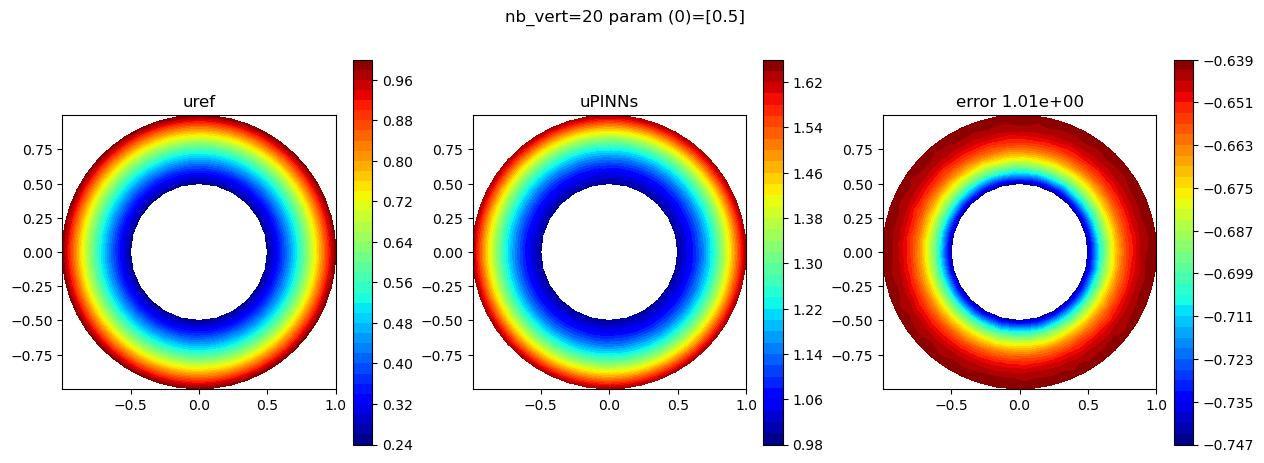


nb_vert=40
hmax =  0.06893171898161234
param = 0 

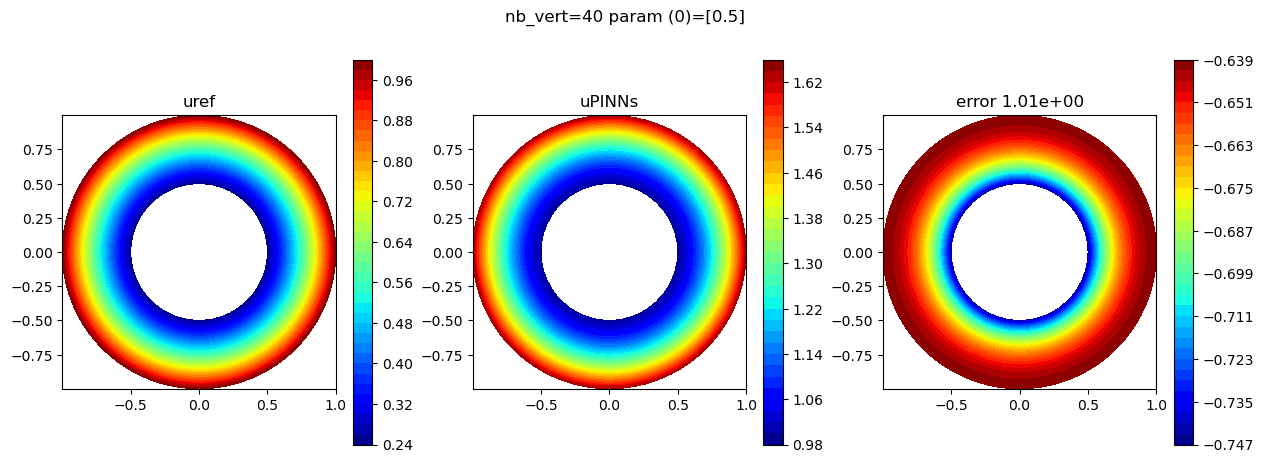

In [9]:
df_PINNs, tab_err_PINNs = run_PINNs(degree,new_run=True)